# Emotions Dataset

This notebook walks you through a slightly more detailed example showing how a Planetoid can be used to visualise the results of an ML pipeline.

We are using the [emotions dataset from OpenML](https://www.openml.org/d/41545) which is a database of features derived from some songs that have been labelled according to their _mood_.

In [1]:
import sys
sys.path.append("..")

In [2]:
#temp, will probably have to modify the demo to use an installed version from PyPi
from planetoids import planetoids as pt
import pandas as pd
import numpy as np

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\autonotebook\__init__.py:18: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



## Pull the data from OpenML.

In order to get the proper target labels we need to follow this `idmax` approach.

In [3]:
from sklearn.datasets import fetch_openml
data = fetch_openml(name='emotions', version=5, target_column=None)
df = pd.DataFrame(data.data, columns=data.feature_names)

#reverse the current one-hot nature of the targets
target = df[data.feature_names[-6:]].idxmax(1).values

#remove the target from the data
df = df.iloc[:,:-6]

#get an int representation of the target labels
b, target_int = np.unique(target, return_inverse=True)

In [4]:
df.shape

(593, 72)

## Preprocessing

Use a cross-validated recursive feature elimination approach to identify the most important features using a forest of extremely randomised trees with max_depth=3

In [5]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import ExtraTreesClassifier
estimator = ExtraTreesClassifier(n_estimators=50, max_depth=3, random_state=42)
selector = RFECV(estimator, step=1, cv=5, verbose=0)
selector = selector.fit(df.values, target)
feature_reduction = round((len(df.columns) - selector.n_features_)/len(df.columns), 2)
print('Feature Reduction: {}%'.format(100*feature_reduction))

Feature Reduction: 76.0%


In [6]:
#print all the features with rank 1
df.columns[selector.ranking_ == 1]

Index(['Mean_Acc1298_Mean_Mem40_Centroid', 'Mean_Acc1298_Mean_Mem40_Rolloff',
       'Mean_Acc1298_Mean_Mem40_MFCC_0', 'Mean_Acc1298_Mean_Mem40_MFCC_1',
       'Std_Acc1298_Mean_Mem40_MFCC_4', 'Std_Acc1298_Mean_Mem40_MFCC_5',
       'Std_Acc1298_Mean_Mem40_MFCC_6', 'Std_Acc1298_Mean_Mem40_MFCC_7',
       'Std_Acc1298_Mean_Mem40_MFCC_9', 'Std_Acc1298_Mean_Mem40_MFCC_10',
       'Std_Acc1298_Mean_Mem40_MFCC_11', 'Std_Acc1298_Std_Mem40_MFCC_3',
       'Std_Acc1298_Std_Mem40_MFCC_5', 'Std_Acc1298_Std_Mem40_MFCC_6',
       'Std_Acc1298_Std_Mem40_MFCC_10', 'Std_Acc1298_Std_Mem40_MFCC_11',
       'BHSUM3'],
      dtype='object')

Plot the 10 most important features

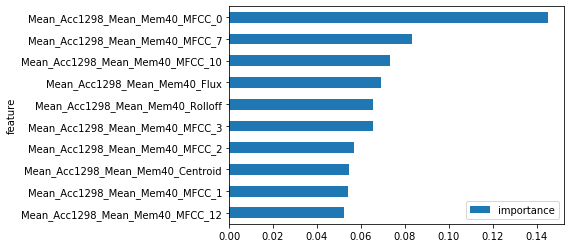

In [7]:
importances = selector.estimator_.feature_importances_
pd.DataFrame(list(zip(df.columns, importances)), columns=['feature', 'importance']).set_index('feature').sort_values('importance').tail(10).plot(kind='barh')

Using the rank 1 features, reduce the dataset down to 2 dimesions

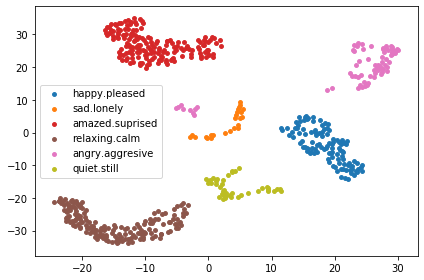

In [8]:
from umap import UMAP #see demo notebook 2 to learn more about umap
embedding = UMAP(n_components=2,
                 metric='cosine',
                 n_neighbors=250, #focus on more global structure
                 angular_rp_forest=True,
                 target_weight=0.7,
                 spread=2.2,
                 min_dist=1.6,
                 random_state=42).fit_transform(df[df.columns[selector.ranking_ == 1]].values, target_int)
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

reduced = pd.DataFrame(embedding, columns=['Component1', 'Component2'])
reduced['Emotion'] = target
reduced['Emotion'] = reduced['Emotion']

x=reduced['Component2']
y=reduced['Component1']

# Get unique names of species
uniq = list(set(target))

# Set the color map to match the number of species
z = range(1,len(uniq))
cmap = plt.get_cmap('tab10')
cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

# Plot each class
for i in range(len(uniq)):
    indx = reduced['Emotion'] == uniq[i]
    plt.scatter(x[indx], y[indx], s=15, color=scalarMap.to_rgba(i), label=uniq[i])

plt.legend()
plt.tight_layout()
plt.show()

As you can see in the scatter plot above, this process has produced some nice clusters we can use to seed a new Planetoid.


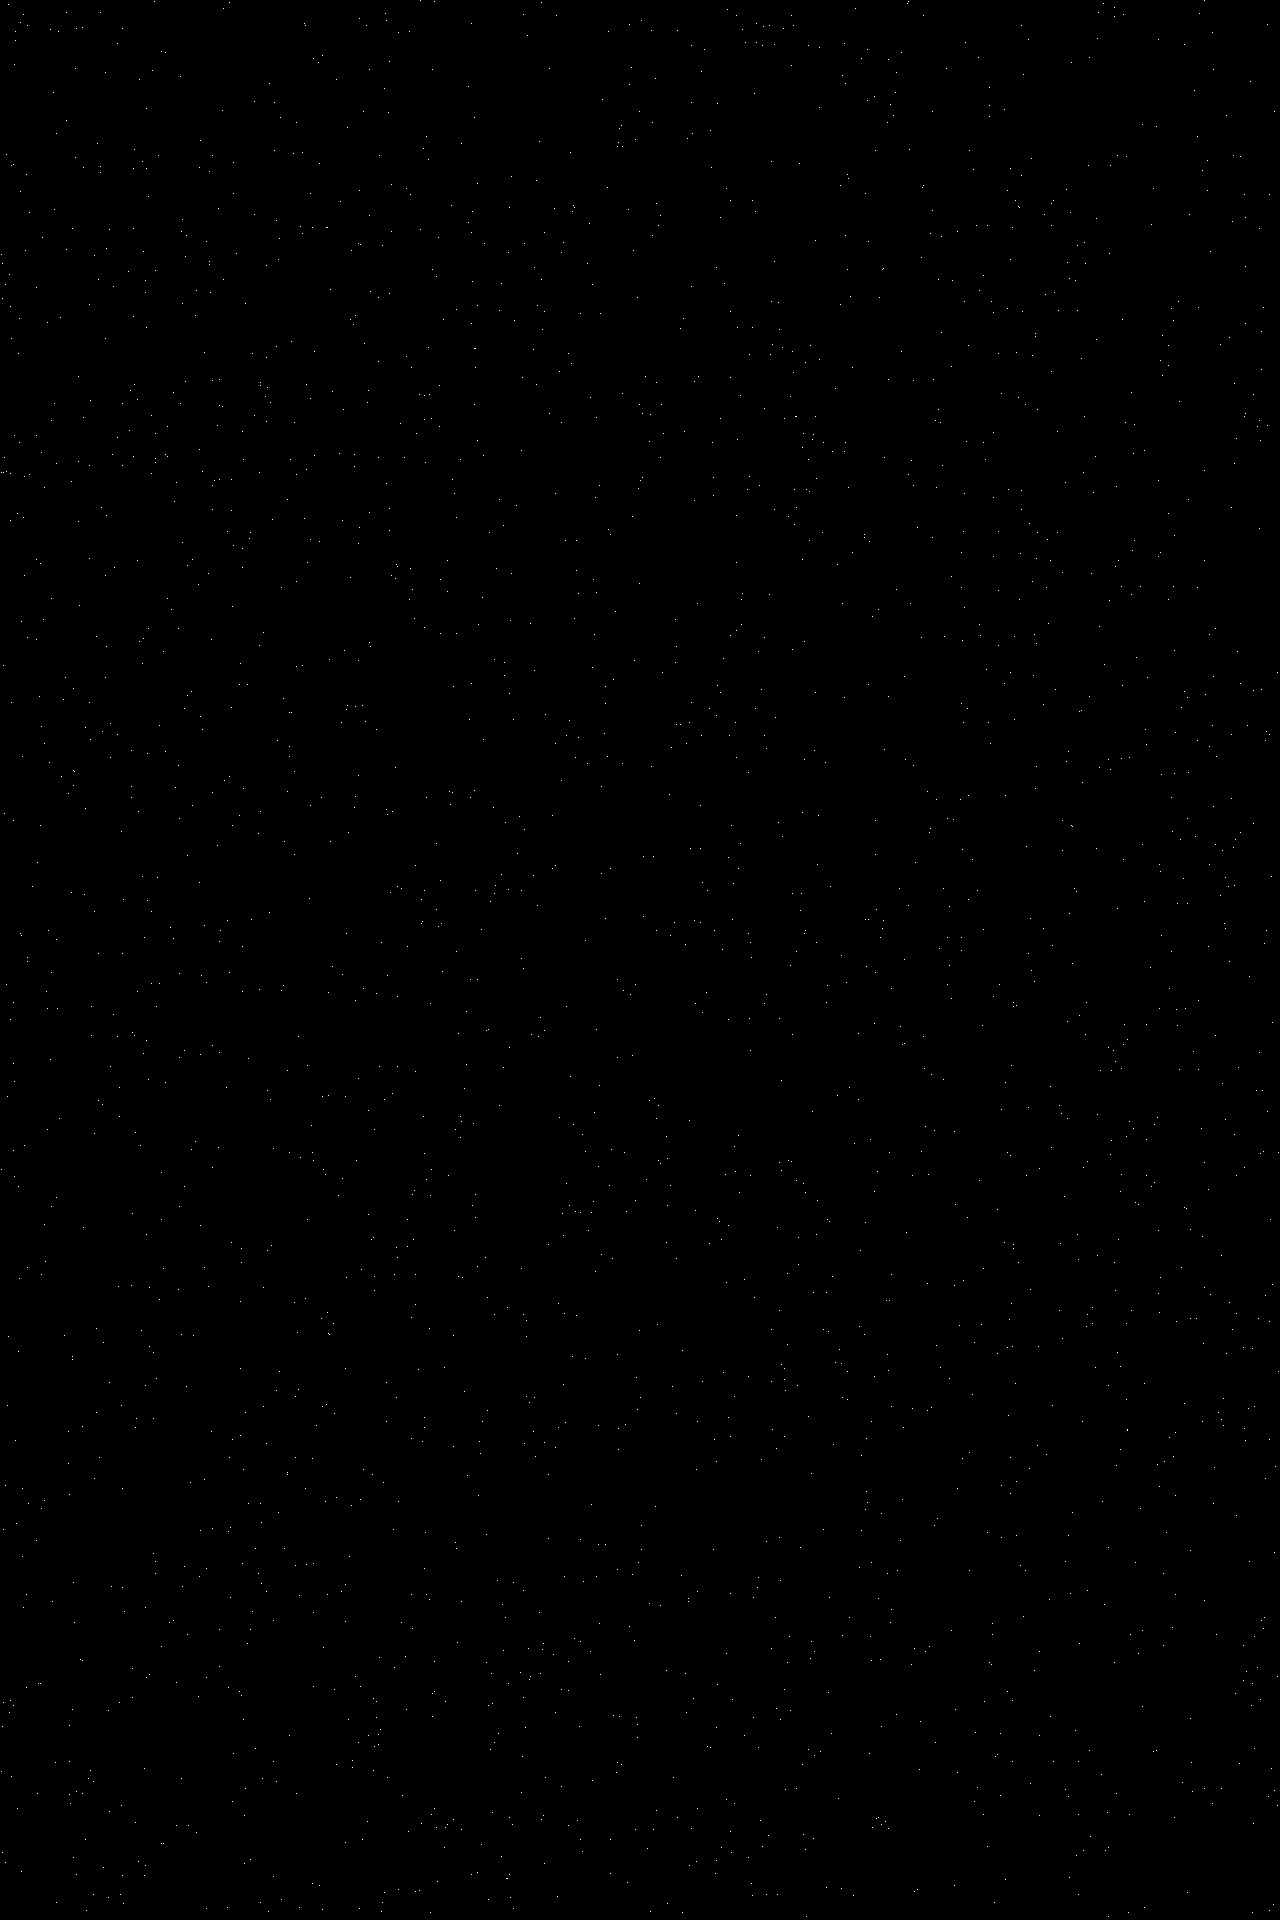

In [9]:
emotions = pt.Planetoid(reduced,
                        'Component1',
                        'Component2',
                        'Emotion')
emotions.fit_terraform(projection="kavrayskiy7",
                       planet_name='Emotions Demo')